# Classical geostatistics (geosclassic wrapper) - indicator variables (3D)

Estimation and simulation for a categorical variable, based on simple and ordinary kriging.
- estimation: estimate probabilities for each category
    - hard data only
    - search ellipsoid or unique neighborhood
- simulation: sequential indicator simulation (SIS) based on simple and ordinary kriging
    - hard data
    - search ellipsoid only

The covariance model can be
- stationary, *i.e.* any parameter (weight (or sill), ranges, orientation angle, etc.) is constant
- non-stationary, *i.e.* with some parameter (weight (or sill), ranges, orientation angle, etc.) depending on the location in the grid. *Note:* with a non-stationary covariance model
    - some functionalities such as getting the sill, range, or plotting the model are not available
    - a unique neighborhood can not be used for estimation

Simple kriging allows to specify the probability of each category, stationary (global) or non-stationary (local). By default the probabilities are set to the proportion of each category in the hard data values (stationary) or a uniform distribution if no hard data is present.

For ordinary kriging: the specified probabilities are used when estimation or simulation is done in a grid cell without any neighbor.

**Remark:** examples in 3D are proposed here.

## Import what is required

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors
import pyvista as pv

# import package 'geone'
import geone as gn

In [2]:
# Show version of python and version of geone
import sys 
print(sys.version_info)
print('geone version: ' + gn.__version__)

sys.version_info(major=3, minor=8, micro=13, releaselevel='final', serial=0)
geone version: 1.1.1


In [3]:
pv.set_jupyter_backend('static') # to get static plots within the jupyter notebook

### Remark
The matplotlib figures can be visualized in *interactive* mode:
- `%matplotlib notebook`: enable interactive mode
- `%matplotlib inline`: disable interactive mode

## Define the category values
A list of category values (facies) must be defined. Let `ncategory` be the length of this list, *i.e.* the number of categories.
- if `ncategory == 1`: the unique category value given must not be equal to 0; this is used for a binary case with values ("unique category value", 0), where 0 indicates the absence of the considered medium; conditioning data values should be "unique category value" or 0
- if `ncategory >= 2`: this is used for a multi-category case with given values (distinct); conditioning data values should be in the list of given values

In [4]:
category_values = [1., 2., 3.]
ncategory = len(category_values)

Set color for each category, and color maps for proportions (for further plots).

In [5]:
categCol = ['lightblue', 'orange', 'darkgreen']
cmap_categ = [gn.customcolors.custom_cmap(['white', c]) for c in categCol]

## Define the covariance model(s)
A covariance model is required for each category. If only one is defined, it is used for every category (it is ''recycled'').

Here in 3D, we define covariance model(s) in 3D: class `covModel3D`.

(See jupyter notebooks `ex_geosclassic_[123]d*.ipynb` for details.)

In [6]:
cov_model = gn.covModel.CovModel3D(elem=[
    ('exponential', {'w':9., 'r':[40, 20, 10]}), # elementary contribution
    ], alpha=-30, beta=-40, gamma=20, name='model-3D example')

## Launching simulation and estimation
The following functions are used:
- `geone.geosclassicinterface.simulateIndicator<n>D` for simulation \<n\>D (sequential indicator simulation, SIS),
- `geone.geosclassicinterface.estimateIndicator<n>D` for estimation \<n\>D (estimate probabilities),

where `n` is the space dimension (`1`, `2`, or `3`).

These functions launch a C program running in parallel (based on *OpenMP*). The number of threads used can be specified by the optional parameter (keyword argument) `nthreads`. Specifying for this parameter a number `-n`, negative or zero, means that the total number of cpus of the system (retrieved by `os.cpu_count()`) except `n` (but at least one) will be used. By default: `nthreads=-1`.

The first argument is the list of category of length `ncategory`, and the (list of) covariance model(s) is given as second argument.

The parameters (keyword arguments) `searchRadiusRelative`, `searchNeighborhoodSortMode`, and
`use_unique_neighborhood` are lists of length `ncategory`. As for the covariance model, if only one value (not a list is given), it is recycled. Each entry in the list is related to the corresponding category in the list of category values given in first argument. These parameters have a similar role as in the functions for simulation and estimation for a continuous values, *i.e.* `geone.geosclassicinterface.simulate<n>D` and `geone.geosclassicinterface.estimate<n>D` (see jupyter notebooks `ex_geosclassic_[123]d*.ipynb` for details.)

*Remark:* the keyword argument `verbose` allows to control what is displayed, `verbose=0`: minimal display, `verbose=1` (default): version and warning(s) encountered, `verbose=2`: version, progress, and warning(s) encountered. Note that due to *buffering*, progress might not be displayed immediately and then could be useless.

### Examples

Define the simulation grid.

In [7]:
nx, ny, nz = 85, 56, 34  # number of cells
dx, dy, dz = 1.0, 1.0, 1.0  # cell unit
ox, oy, oz = 0.0, 0.0, 0.0  # origin

dimension = (nx, ny, nz)
spacing = (dx, dy, dz)
origin = (ox, oy, oz)

### Unconditional simulations (function `geone.geosclassicinterface.simulateIndicator<n>D`)

In [8]:
nreal = 50
np.random.seed(321)
geosclassic_output = gn.geosclassicinterface.simulateIndicator3D(
    category_values, cov_model, dimension, spacing, origin, method='simple_kriging', 
    searchRadiusRelative=1.0, nneighborMax=12, nreal=nreal)

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20220627 / OpenMP 7 thread(s)]
Geos-Classic run complete


### Retrieve the results (and display)
The function `geone.geosclassicinterface.simulateIndicator<n>D` returns the dictionary

`geosclassic_output = {'image':image, 'nwarning':nwarning, 'warnings':warnings}`

The realizations are stored in `geosclassic_output['image']`, an *image* (class `geone.img.Img`) with as many variables as realizations (the i-th variable being the i-th realization).

The total number of warning(s) encountered during the run are stored in `geosclassic_output['nwarning']` (*int*), and all the distinct warning messages are stored in `geosclassic_output['warnings']` (it is a list, possibly empty).

In [9]:
# Total number of warning(s), and warning messages
geosclassic_output['nwarning'], geosclassic_output['warnings']

(0, [])

In [10]:
# Retrieve the realizations
simul = geosclassic_output['image']

# Compute proportion of each category (pixel-wise)
simul_prop = gn.img.imageCategProp(simul, category_values)

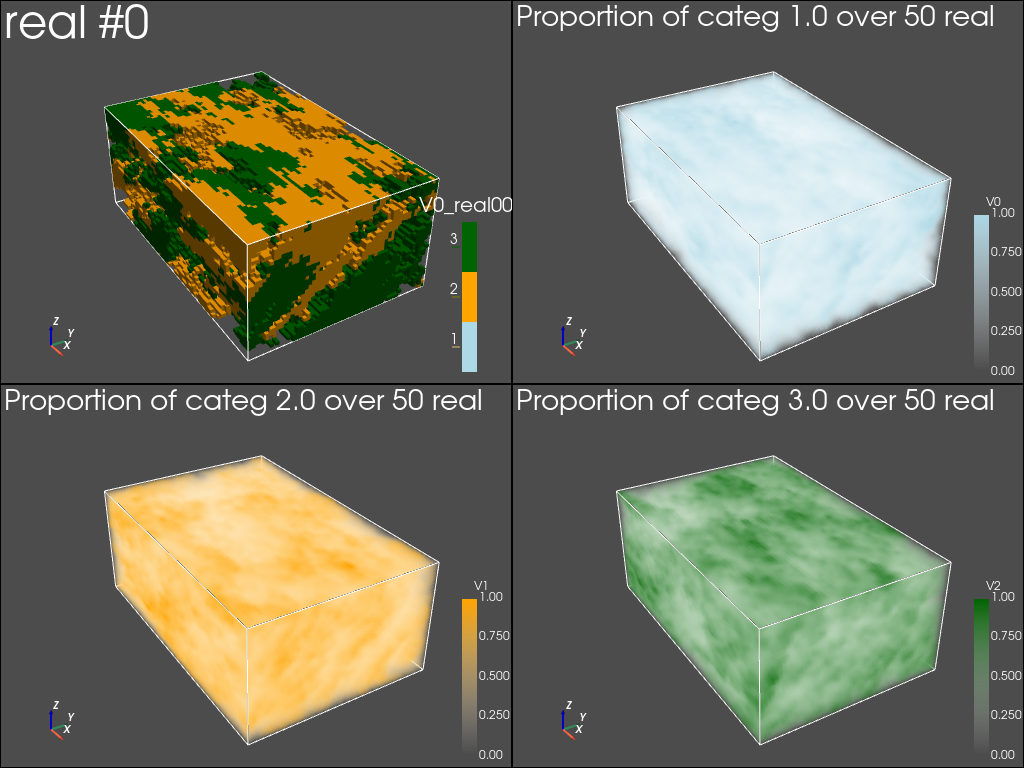

In [11]:
# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))


pp.subplot(0, 0)
gn.imgplot3d.drawImage3D_surface(simul, plotter=pp, filtering_value=[2,3], 
                                 custom_scalar_bar_for_equidistant_categories=True, 
                                 custom_colors=categCol,
                                 scalar_bar_kwargs={'title_font_size':20, 'vertical':True},
                                 text='real #0')

for i in range(ncategory):
    ir, ic = np.divmod(i+1, 2)
    pp.subplot(ir, ic)
    gn.imgplot3d.drawImage3D_volume(simul_prop, iv=i, plotter=pp,
                                    text='Proportion of categ {} over {} real'.format(category_values[i], nreal),
                                    cmin=0, cmax=1,
                                    cmap=cmap_categ[i],
                                    scalar_bar_kwargs={'vertical':True, 'label_font_size':12})

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

### Conditional simulations (hard data) (function `geone.geosclassicinterface.simulateIndicator<n>D`)
Define hard data. Note that the conditioning values will be attached to the grid cells containing the corresponding conditioning locations.

In [12]:
x = np.array([[ 10.5,  20.5,  3.5], # 1st point
              [ 40.5,  10.5, 10.5], # 2nd point
              [ 30.5,  40.5, 20.5], # 3rd point
              [ 30.5,  30.5, 30.5]]) # 4th point
v = [ 1., 2., 1., 3.] # values

Launch the simulations and plot.

In [13]:
nreal = 50
np.random.seed(321)
geosclassic_output = gn.geosclassicinterface.simulateIndicator3D(
    category_values, cov_model, dimension, spacing, origin, 
    x=x, v=v, method='simple_kriging', 
    searchRadiusRelative=1.0, nneighborMax=12, nreal=nreal)

# Retrieve the realizations
simul = geosclassic_output['image']

# Compute proportion of each category (pixel-wise)
simul_prop = gn.img.imageCategProp(simul, category_values)

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20220627 / OpenMP 7 thread(s)]
Geos-Classic run complete


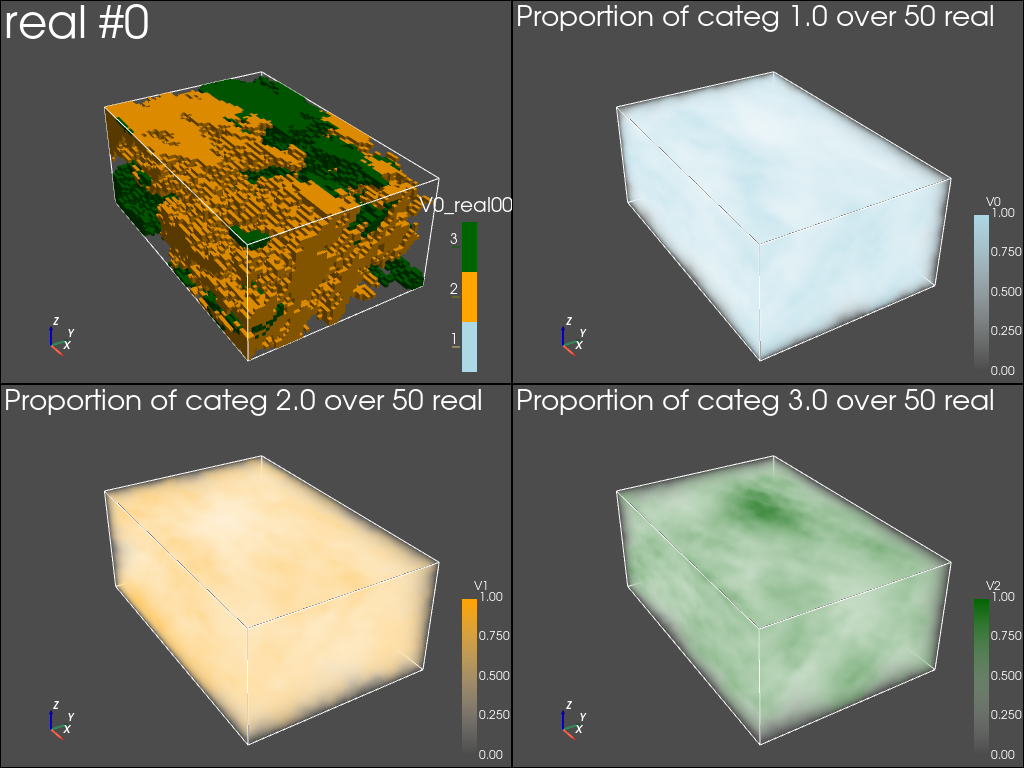

In [14]:
# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

pp.subplot(0, 0)
gn.imgplot3d.drawImage3D_surface(simul, plotter=pp, filtering_value=[2,3], 
                                 custom_scalar_bar_for_equidistant_categories=True, 
                                 custom_colors=categCol,
                                 scalar_bar_kwargs={'title_font_size':20, 'vertical':True},
                                 text='real #0')

for i in range(ncategory):
    ir, ic = np.divmod(i+1, 2)
    pp.subplot(ir, ic)
    gn.imgplot3d.drawImage3D_volume(simul_prop, iv=i, plotter=pp,
                                    text='Proportion of categ {} over {} real'.format(category_values[i], nreal),
                                    cmin=0, cmax=1,
                                    cmap=cmap_categ[i],
                                    scalar_bar_kwargs={'vertical':True, 'label_font_size':12})

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

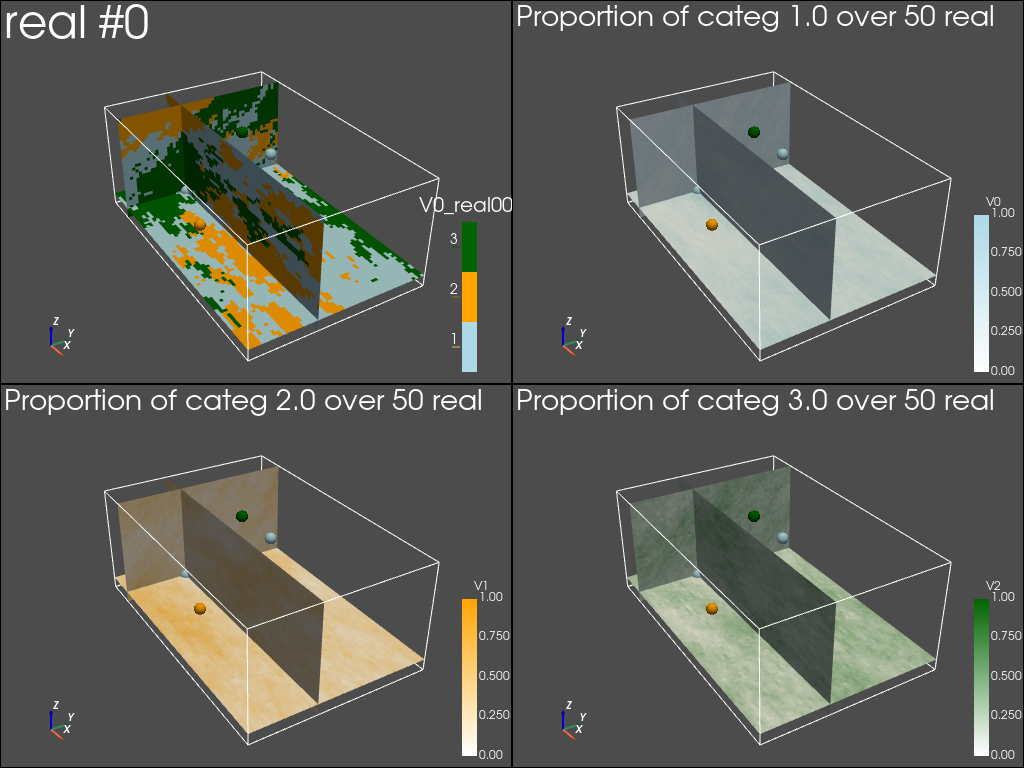

In [15]:
# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

# data points to be added to 3D plot
data_points = pv.PolyData(x)
# ... set color for data points according to their value
data_points_col = [matplotlib.colors.to_rgb(categCol[np.where(np.asarray(category_values) == i)[0][0]]) for i in v] 
    # color for data points according to their value
data_points['colors'] = data_points_col

pp.subplot(0, 0)
gn.imgplot3d.drawImage3D_slice(simul, plotter=pp,
                               slice_normal_x=x[0,0],
                               slice_normal_y=x[0,1],
                               slice_normal_z=x[0,2],
                               custom_scalar_bar_for_equidistant_categories=True, 
                                custom_colors=categCol,
                               scalar_bar_kwargs={'title_font_size':20, 'vertical':True},
                               text='real #0')
pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

for i in range(ncategory):
    ir, ic = np.divmod(i+1, 2)
    pp.subplot(ir, ic)
    gn.imgplot3d.drawImage3D_slice(simul_prop, iv=i, plotter=pp,
                                   slice_normal_x=x[0,0],
                                   slice_normal_y=x[0,1],
                                   slice_normal_z=x[0,2],
                                   text='Proportion of categ {} over {} real'.format(category_values[i], nreal),
                                   cmap=cmap_categ[i], cmin=0, cmax=1,
                                   scalar_bar_kwargs={'vertical':True, 'label_font_size':12})
    pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

### Estimation: estimate probabilities (by kriging)
#### Function `geone.geosclassicinterface.estimateIndicator<n>D`

In [16]:
# Increase searchRadiusRelative to avoid "discontinuities"
# geosclassic_output = gn.geosclassicinterface.estimateIndicator3D(
#     category_values, cov_model, dimension, spacing, origin, 
#     x=x, v=v, method='simple_kriging',
#     searchRadiusRelative=2.0)

# Or use a unique neighborhood
geosclassic_output = gn.geosclassicinterface.estimateIndicator3D(
    category_values, cov_model, dimension, spacing, origin, 
    x=x, v=v, method='simple_kriging',
    use_unique_neighborhood=True)

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20220627 / OpenMP 7 thread(s)]
Geos-Classic run complete


### Retrieve the results (and display)
The function `geone.geosclassicinterface.estimateIndicator<n>D` returns the dictionary

`geosclassic_output = {'image':image, 'nwarning':nwarning, 'warnings':warnings}`

The estimate probabilities are stored in `geosclassic_output['image']`, an *image* (class `geone.img.Img`) with `ncategory` variables: the i-th variable is the estimated probabilities for the i-th category.

As for the function `geone.geosclassicinterface.simulateIndicator<n>D`, the warning(s) encountered during the run are stored in `geosclassic_output['nwarning']` (*int*), and all the distinct warning messages are stored in `geosclassic_output['warnings']` (it is a list, possibly empty).

In [17]:
# Retrieve the results of estimation
estim = geosclassic_output['image']

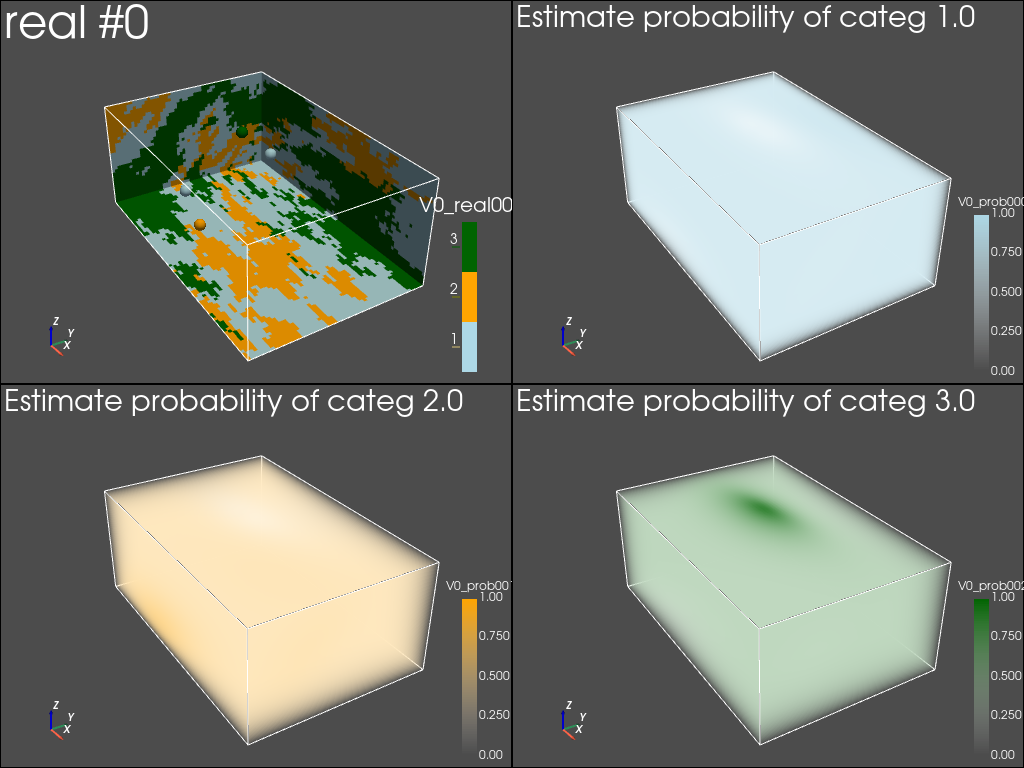

In [18]:
# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

pp.subplot(0, 0)
gn.imgplot3d.drawImage3D_slice(simul, plotter=pp,
                               slice_normal_x=simul.xmin()+.001,
                               slice_normal_y=simul.ymax()-.001,
                               slice_normal_z=simul.zmin()+.001,
                               custom_scalar_bar_for_equidistant_categories=True, 
                               custom_colors=categCol,
                               scalar_bar_kwargs={'title_font_size':20, 'vertical':True},
                               text='real #0')
pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

for i in range(ncategory):
    ir, ic = np.divmod(i+1, 2)
    pp.subplot(ir, ic)
#for i in range(ncategory):
#    pp.subplot(0, i)
    gn.imgplot3d.drawImage3D_volume(estim, iv=i, plotter=pp,
                                    text='Estimate probability of categ {}'.format(category_values[i]),
                                    cmap=cmap_categ[i], cmin=0, cmax=1,
                                    scalar_bar_kwargs={'vertical':True, 'label_font_size':12})

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

### Simulations with prescribed probabilities
Probabilities for the categories can be specified if simple kriging is used, they can be stationary (constant) or non-stationary. By default, the proportions of the categories in the conditioning data are used (or zero if no conditioning data) (constant).

With `ncategory>1`, the sum of probabilities (at each pixel if non-stationary) must sum to 1. If `ncategory==1`, only one value (per pixel if non-stationary) is given which must be between 0 and 1. 

### Simulations with constant probabilities

In [19]:
probability = [.1, .2, .7] # should sum to 1
# Simulation
nreal = 1
np.random.seed(321)
geosclassic_output = gn.geosclassicinterface.simulateIndicator3D(
    category_values, cov_model, dimension, spacing, origin, 
    x=x, v=v, probability=probability, nreal=nreal)
simul = geosclassic_output['image']

# Estimation
geosclassic_output = gn.geosclassicinterface.estimateIndicator3D(
    category_values, cov_model, dimension, spacing, origin, 
    x=x, v=v, probability=probability, use_unique_neighborhood=True)
estim = geosclassic_output['image']

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20220627 / OpenMP 7 thread(s)]
Geos-Classic run complete
Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20220627 / OpenMP 7 thread(s)]
Geos-Classic run complete


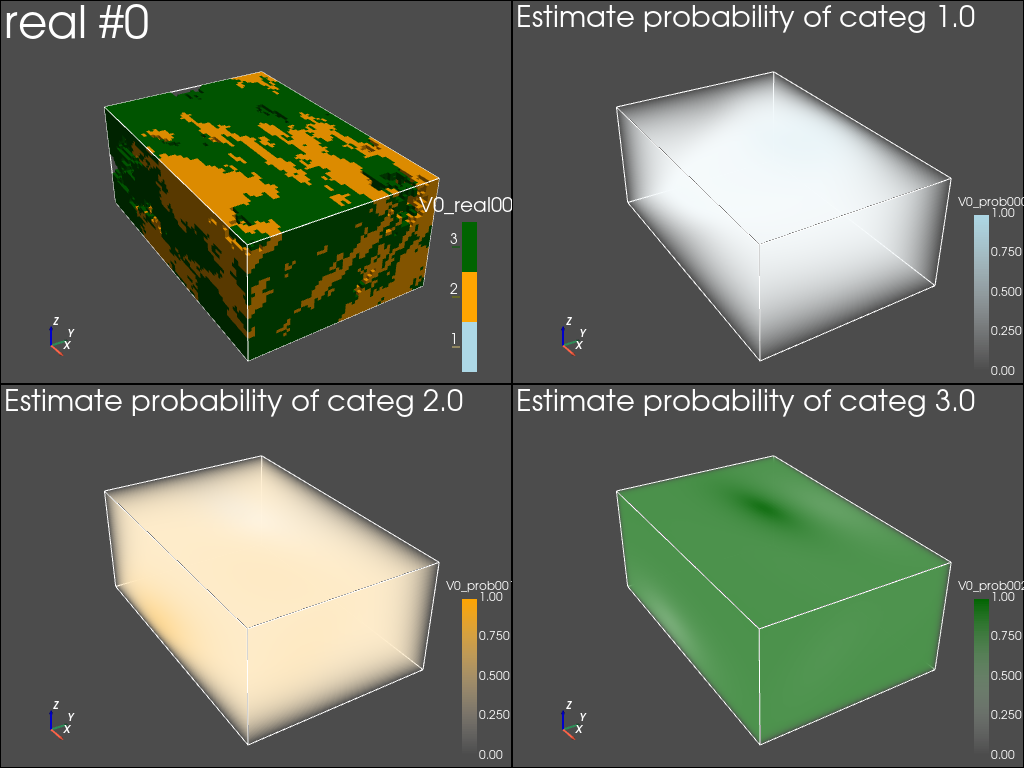

In [20]:
# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

pp.subplot(0, 0)
gn.imgplot3d.drawImage3D_surface(simul, plotter=pp, filtering_value=[2,3], 
                                 custom_scalar_bar_for_equidistant_categories=True, 
                                 custom_colors=categCol,
                                 scalar_bar_kwargs={'title_font_size':20, 'vertical':True},
                                 text='real #0')

for i in range(ncategory):
    ir, ic = np.divmod(i+1, 2)
    pp.subplot(ir, ic)
    gn.imgplot3d.drawImage3D_volume(estim, iv=i, plotter=pp,
                                    text='Estimate probability of categ {}'.format(category_values[i]),
                                    cmap=cmap_categ[i], cmin=0, cmax=1,
                                    scalar_bar_kwargs={'vertical':True, 'label_font_size':12})

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

### Simulations with non-stationary probabilities
Set varying probabilities over the simulation domain.

In [21]:
# Coordinates of the center of grid cells
xg = ox + dx*(0.5+np.arange(nx))
yg = oy + dy*(0.5+np.arange(ny))
zg = oz + dz*(0.5+np.arange(nz))

# Create a meshgrid from the center of grid cells
zz, yy, xx = np.meshgrid(zg, yg, xg, indexing='ij')

# Define probability maps for each category
c = 0.9
p1 = xx + yy + zz
p1 = c * (p1 - np.min(p1))/ (np.max(p1) - np.min(p1))
p2 = c - p1
p0 = (1. - c) * np.ones_like(p1) # 1.0 - p1 - p2 # constant map (0.1)

probability = np.array((p0, p1, p2))

# Fill image for display
im = gn.img.Img(nx, ny, nz, dx, dy, dz, ox, oy, oz, nv=3, val=probability)

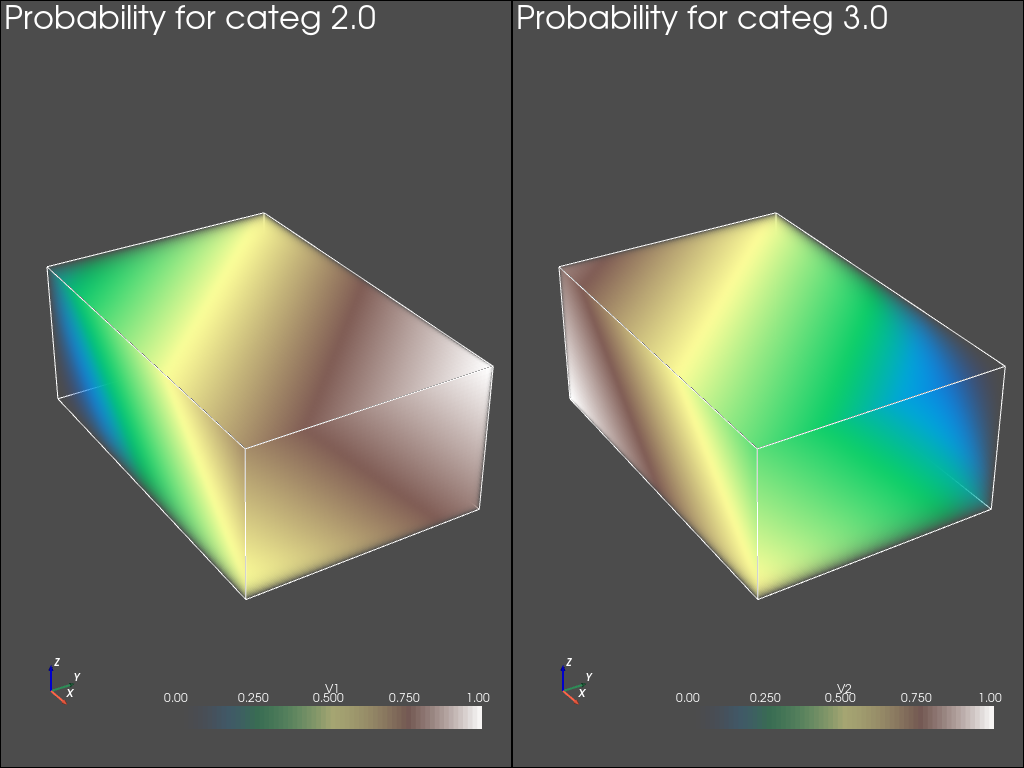

In [22]:
# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(1,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(1,2))

for i in range(1, ncategory):
    pp.subplot(0, i-1)
    gn.imgplot3d.drawImage3D_volume(im, iv=i, plotter=pp,
                                    text='Probability for categ {}'.format(category_values[i]),
                                    cmap='terrain', cmin=0, cmax=1,
                                    scalar_bar_kwargs={'vertical':False, 'label_font_size':12})

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

In [23]:
nreal = 50
np.random.seed(321)
geosclassic_output = gn.geosclassicinterface.simulateIndicator3D(
    category_values, cov_model, dimension, spacing, origin, 
    x=x, v=v, method='simple_kriging',
    probability=probability,
    searchRadiusRelative=1.0, nneighborMax=12, nreal=nreal)

# Retrieve the realizations
simul = geosclassic_output['image']

# Compute proportion of each category (pixel-wise)
simul_prop = gn.img.imageCategProp(simul, category_values)

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20220627 / OpenMP 7 thread(s)]
Geos-Classic run complete


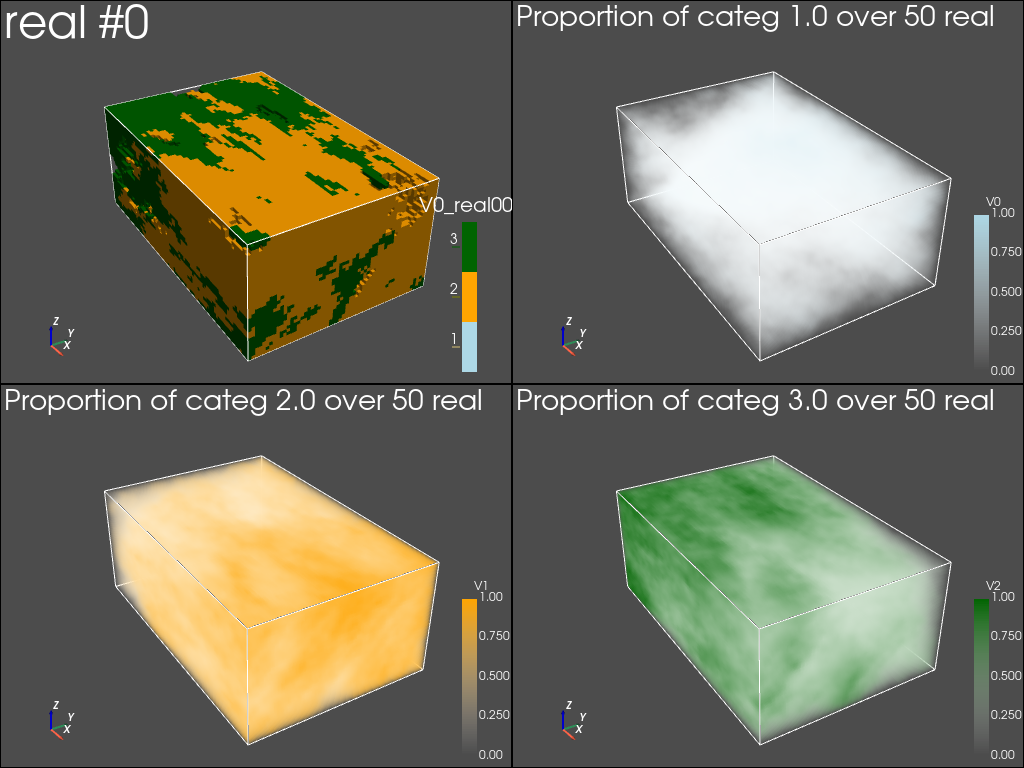

In [24]:
# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

pp.subplot(0, 0)
gn.imgplot3d.drawImage3D_surface(simul, plotter=pp, filtering_value=[2,3], 
                                 custom_scalar_bar_for_equidistant_categories=True, 
                                 custom_colors=categCol,
                                 scalar_bar_kwargs={'title_font_size':20, 'vertical':True},
                                 text='real #0')

for i in range(ncategory):
    ir, ic = np.divmod(i+1, 2)
    pp.subplot(ir, ic)
    gn.imgplot3d.drawImage3D_volume(simul_prop, iv=i, plotter=pp,
                                    text='Proportion of categ {} over {} real'.format(category_values[i], nreal),
                                    cmap=cmap_categ[i], cmin=0, cmax=1,
                                    scalar_bar_kwargs={'vertical':True, 'label_font_size':12})

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

## Example with non-stationary covariance model
As for simulation and estimation for a continuous variable, non-stationary covariance model can be defined. For details, see jupyter notebooks `ex_geosclassic_[123]d_non_stat_cov.ipynb`.

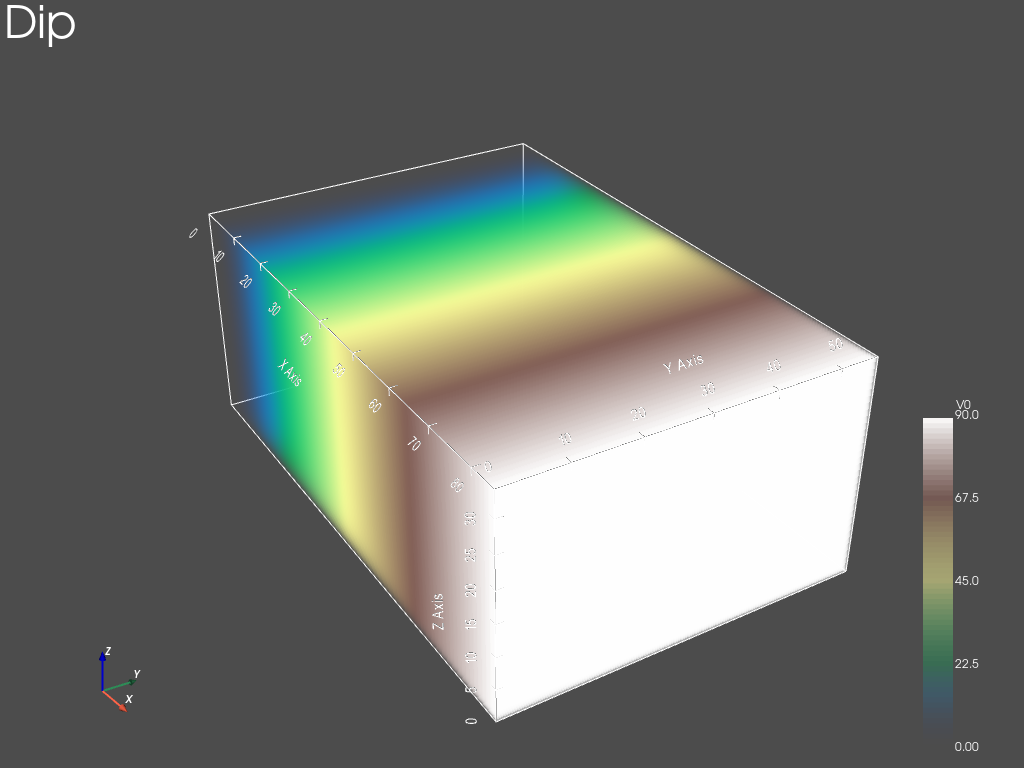

In [25]:
xgrid = ox + (np.arange(nx)+0.5)*dx # x coordinate along the x-axis of the sim. grid
ygrid = oy + (np.arange(ny)+0.5)*dy # y coordinate along the y-axis of the sim. grid
zgrid = oz + (np.arange(nz)+0.5)*dz # z coordinate along the z-axis of the sim. grid

# x, y, z coordinates of every sim. grid cell
zz, yy, xx = np.meshgrid(zgrid, ygrid, xgrid, indexing='ij')

# Define azimuth angle over the simulation grid
beta = 0 + (xx-xx.min())/(xx.max()-xx.min())*90.

im_beta = gn.img.Img(nx, ny, nz, dx, dy, dz, ox, oy, oz, nv=1, val=beta)

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(notebook=False)
# ... inline
pp = pv.Plotter()

gn.imgplot3d.drawImage3D_volume(im_beta, plotter=pp,
                                text='Dip',
                                cmap='terrain',
                                show_bounds=True,
                                scalar_bar_kwargs={'vertical':True, 'label_font_size':12})

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

In [26]:
# Define the non-stationary covariance model 
cov_model = gn.covModel.CovModel3D(elem=[
    ('exponential', {'w':9., 'r':[10, 40, 10]}), # elementary contribution
    ], alpha=90, beta=beta, gamma=0, name='model-3D example')

In [27]:
# Conditioning data (as above)
x = np.array([[ 10.5,  20.5,  3.5], # 1st point
              [ 40.5,  10.5, 10.5], # 2nd point
              [ 30.5,  40.5, 20.5], # 3rd point
              [ 30.5,  30.5, 30.5]]) # 4th point
v = [ 1., 2., 1., 3.] # values

In [28]:
# Simulation
nreal = 50
np.random.seed(321)
geosclassic_output = gn.geosclassicinterface.simulateIndicator3D(
    category_values, cov_model, dimension, spacing, origin, 
    x=x, v=v, method='simple_kriging', 
    searchRadiusRelative=1.0, nneighborMax=12, nreal=nreal)

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20220627 / OpenMP 7 thread(s)]
Geos-Classic run complete


In [29]:
# Retrieve the realizations
simul = geosclassic_output['image']

# Compute proportion of each category (pixel-wise)
simul_prop = gn.img.imageCategProp(simul, category_values)

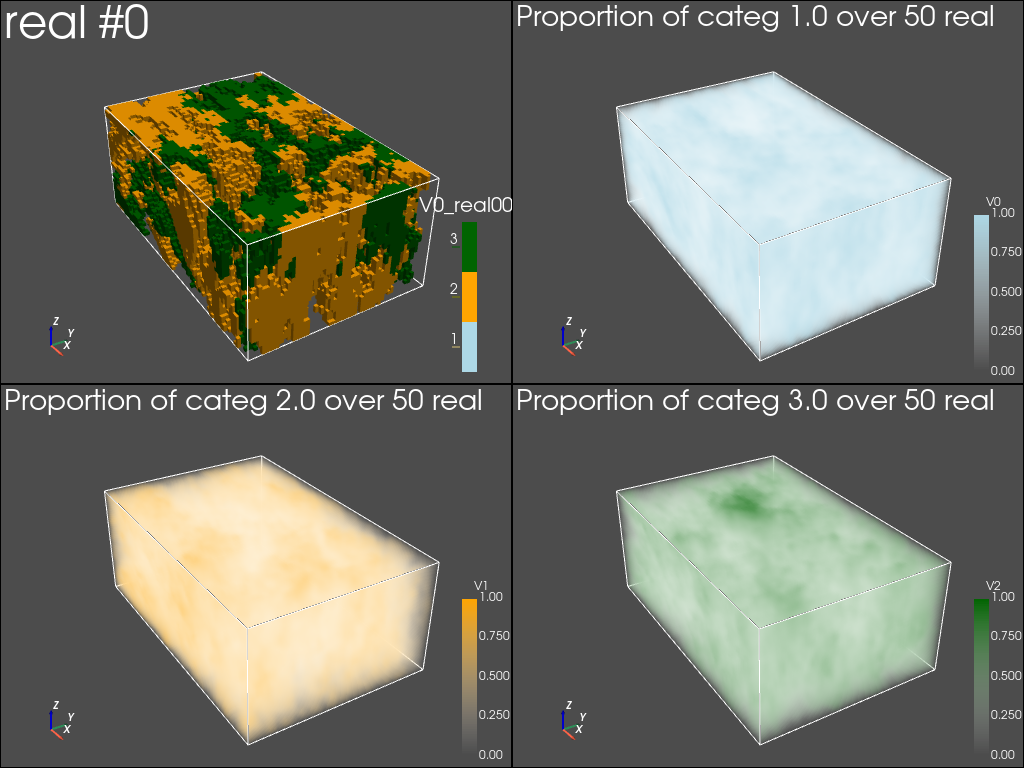

In [30]:
# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

pp.subplot(0, 0)
gn.imgplot3d.drawImage3D_surface(simul, plotter=pp, filtering_value=[2,3], 
                                 custom_scalar_bar_for_equidistant_categories=True, 
                                 custom_colors=categCol,
                                 scalar_bar_kwargs={'title_font_size':20, 'vertical':True},
                                 text='real #0')

for i in range(ncategory):
    ir, ic = np.divmod(i+1, 2)
    pp.subplot(ir, ic)
    gn.imgplot3d.drawImage3D_volume(simul_prop, iv=i, plotter=pp,
                                    text='Proportion of categ {} over {} real'.format(category_values[i], nreal),
                                    cmap=cmap_categ[i], cmin=0, cmax=1,
                                    scalar_bar_kwargs={'vertical':True, 'label_font_size':12})

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

#### Estimation: estimate probabilities
*Note:* unique search neighorhood can not be used with a non-stationary covariance model.

Extract random points from the first realization to set conditioning data.

In [31]:
im = gn.img.Img(nx, ny, nz, dx, dy, dz, ox, oy, oz, nv=1, val=simul.val[0])
ps = gn.img.extractRandomPointFromImage(im, 600, seed=444)
new_x = ps.val[0:3].T # location of conditioning data
new_v = ps.val[3]     # value at conditioning data

In [32]:
# Increase searchRadiusRelative to avoid "discontinuities"
geosclassic_output = gn.geosclassicinterface.estimateIndicator3D(
    category_values, cov_model, dimension, spacing, origin, 
    x=new_x, v=new_v, method='simple_kriging',
    searchRadiusRelative=2.0)
estim = geosclassic_output['image']

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20220627 / OpenMP 7 thread(s)]
Geos-Classic run complete


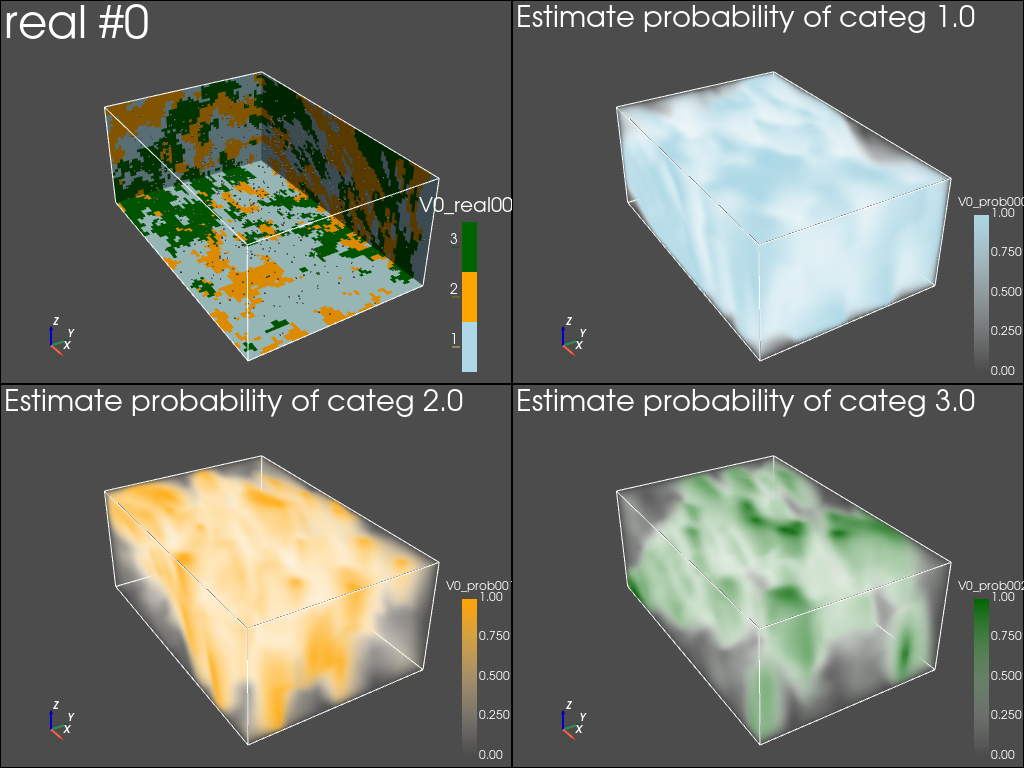

In [33]:
# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

# data points to be added to 3D plot
new_data_points = pv.PolyData(new_x)

pp.subplot(0, 0)
gn.imgplot3d.drawImage3D_slice(simul, plotter=pp,
                               slice_normal_x=simul.xmin()+.001,
                               slice_normal_y=simul.ymax()-.001,
                               slice_normal_z=simul.zmin()+.001,
                               custom_scalar_bar_for_equidistant_categories=True, 
                               custom_colors=categCol,
                               scalar_bar_kwargs={'title_font_size':20, 'vertical':True},
                               text='real #0')
pp.add_mesh(new_data_points, color='gray', point_size=2., render_points_as_spheres=True)

for i in range(ncategory):
    ir, ic = np.divmod(i+1, 2)
    pp.subplot(ir, ic)
#for i in range(ncategory):
#    pp.subplot(0, i)
    gn.imgplot3d.drawImage3D_volume(estim, iv=i, plotter=pp,
                                    text='Estimate probability of categ {}'.format(category_values[i]),
                                    cmin=0, cmax=1,
                                    cmap=cmap_categ[i],
                                    scalar_bar_kwargs={'vertical':True, 'label_font_size':12})

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified